# Classification Exercises: 


## Classification of RR-Lyrae stars

For completeness, we'll starts with the results of the first lecture using Gaussian Naive Bayes. We'll also use scikit-learn tools to calculate scores

In [1]:
from astroML.datasets import fetch_rrlyrae_combined 
from sklearn.naive_bayes import GaussianNB
from astroML.classification import GMMBayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import sklearn.discriminant_analysis 

In [3]:
X, y = fetch_rrlyrae_combined()
X.shape, y.shape, y.reshape(-1,1).shape

((93141, 4), (93141,), (93141, 1))

In [4]:
#X, y = fetch_rrlyrae_combined() # X is a 4-D color-color-color-color space
# Look the data format and re-organise the columns order for better 1 color classification
print(X.shape, y.shape)
X = X[:, [1, 0, 2, 3]]  # rearrange columns for better 1-color results
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(93141, 4) (93141,)


((69855, 4), (23286, 4), (69855,), (23286,))

Text(0, 0.5, 'g-r')

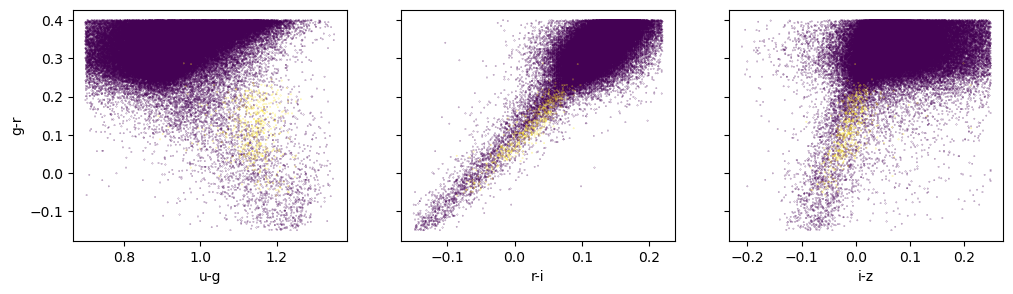

In [5]:
# A simple but more limited visualisation of the data 
f, ax = plt.subplots(ncols=3, figsize = (12, 3), sharey=True)
xlab = ['g-r', 'u-g', 'r-i', 'i-z']

for i in range(3): 
    ax[i].scatter(X[:, i+1], X[:,0], c=y, marker='.', s=0.1, cmap='viridis')
    ax[i].set_xlabel(xlab[i+1])
ax[0].set_ylabel('g-r')


In [6]:
# What is the typical fraction of RR-lyrae in the sample? 
print('Number of Stars = %i - Number of RRLyrae =%i'%(len(y[y ==0]), len(y[y==1]) ))
print('Fraction of RRLyrae in the sample = %.3f' %(float(len(y[y ==1])) / len(y[y==0])))

Number of Stars = 92658 - Number of RRLyrae =483
Fraction of RRLyrae in the sample = 0.005


In [7]:
# Visualisation with pandas pairplot ... Quite computationally demanding ! -> avoid it 
import pandas as pd
import seaborn as sns
#data_4df = np.column_stack((X, y))
# only subsample of the data to save a bit of memory for visualisation
data_4df = np.column_stack((X[::5, :], y[::5]))
df = pd.DataFrame(data_4df, columns=['g-r', 'u-g', 'r-i', 'i-z', 'class'])

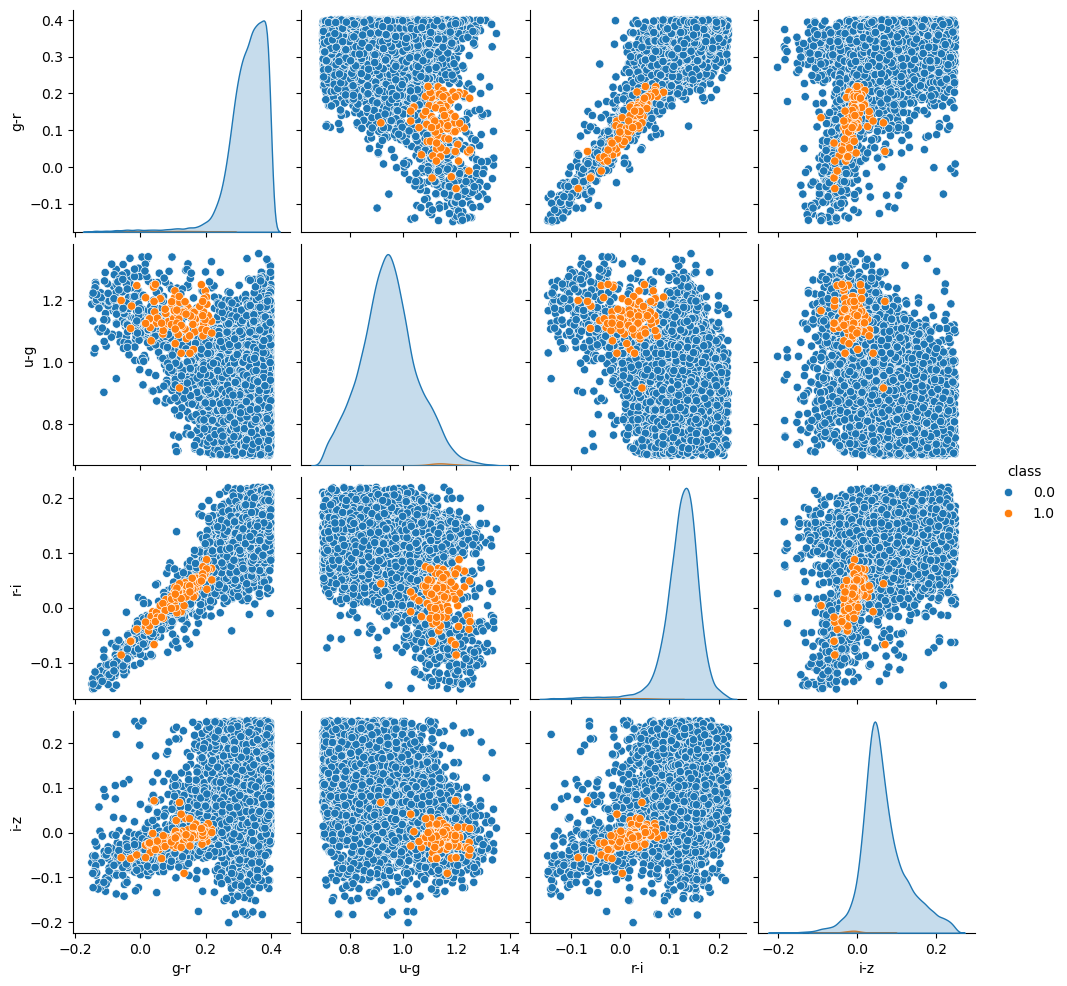

In [8]:
# this is a very demanding plot ! 
sns.pairplot(df, hue='class')

In [9]:
def calc_RRLyrae_score(clf, X_train, y_train, X_test, y_test):
    '''
    Calculate, for a classifier instance 'model()' , the values of the completeness
    and contamination, and "average accuracy"
    This function is designed to test for the 4 colors used in the RR-LYRAE dataset 
    '''
    completeness, contamination, accuracy = [], [], []
    classifier = []
    for n_colors in range(1, 5):
    #    model = clf()
        clf.fit(X_train[:, :n_colors], y_train) # 3. fit model to data
        y_predict = clf.predict(X_test[:, :n_colors]) # 4. predict on new data
        tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
        cpl = tp / (tp + fn)
        cont = fp / (tp + fp)
        completeness.append(cpl)
        contamination.append(cont)
        acc = accuracy_score(y_test, y_predict)
        accuracy.append(acc)
        classifier.append(clf)
    return completeness, contamination, accuracy, classifier

Contamination = 0.82, Completeness = 0.90, accuracy = 0.98


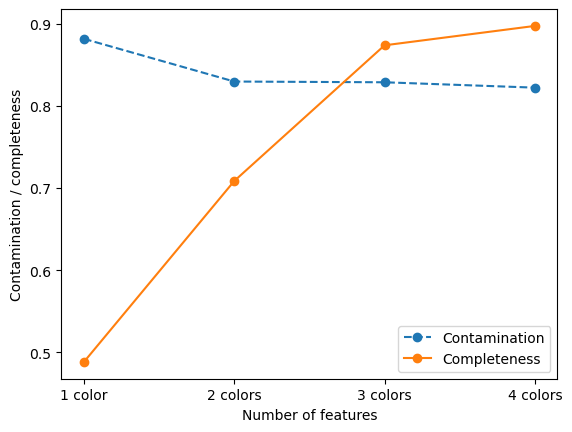

In [10]:
model = GaussianNB()
compl, contam, acc, classifier =  calc_RRLyrae_score(model, X_train, y_train, X_test, y_test)  
Nfeatures = ['1 color', '2 colors', '3 colors', '4 colors']
plt.plot(Nfeatures, np.array(contam), marker='o', ls='--', label='Contamination')
plt.plot(Nfeatures, np.array(compl), marker='o', ls='-', label='Completeness')
plt.legend()
plt.xlabel('Number of features')
plt.ylabel('Contamination / completeness')
print('Contamination = %.2f, Completeness = %.2f, accuracy = %.2f' %(contam[3], compl[3], acc[3]))

completeness_GNB = np.array(compl).copy()
contamination_GNB = np.array(contam).copy()
accuracy_GNB = np.array(acc).copy()

In [11]:
def maketwocolors_RRlyrae_DB(model):
    '''
    Visualisation of the decision boundary of RR-lyrae for first 2 colors
    '''
    xlim = (-0.15, 0.4)  # feature 2 (u-g)
    ylim = (0.7, 1.35)   # feature 0 (g-r) 
    
    # The predict_proba method takes as input an X-like array with shape "nsample, nfeatures"
    # Here we will calculate the proba over a grid of points 
    # Let's first use meshgrid to make the grid 
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 81),
                         np.linspace(ylim[0], ylim[1], 71))
    
    # Now we reshape the grid to have the format needed for X 
    X_grid = np.column_stack([xx.ravel(), yy.ravel()])
    
    P_grid = model.predict_proba(X_grid[:, :2]) # I only take the first 2 colors
    print(P_grid.shape)
    # Now we need to reshape the predicted probabilities to be able to plot using our X-Y Meshgrids
    # We are interested in the RR-lyrae which is the class in column #1 
    P_grid = P_grid[:, 1].reshape(xx.shape).copy()  
    # plot the decision boundary plot 
    f, ax = plt.subplots(figsize=(6,6))
    
    # To show the change of probabilities coded based on the colors... 
    im = ax.imshow(P_grid, origin='lower', aspect='auto', cmap=plt.cm.binary, extent=xlim + ylim) 
    # Note in the above command the extent argument that enables to change "pixels" into the "magnitude" limits
    im.set_clim(-0.5, 1.0)
    # Plot the decision boundary ! 
    ax.contour(xx, yy, P_grid, [0.5], colors='k')
    
    # Now, overlay the data points ... 
    im = ax.scatter(X[:, 0], X[:, 1], c=y[:],
                    s=4, lw=0, cmap=plt.cm.Oranges_r)
    im.set_clim(-0.5, 1.0)
    
    # And finally fine tune the axis display 
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    ax.set_xlabel('$g-r$')
    ax.set_ylabel('$u-g$')
    return ax

(5751, 2)


<Axes: xlabel='$g-r$', ylabel='$u-g$'>

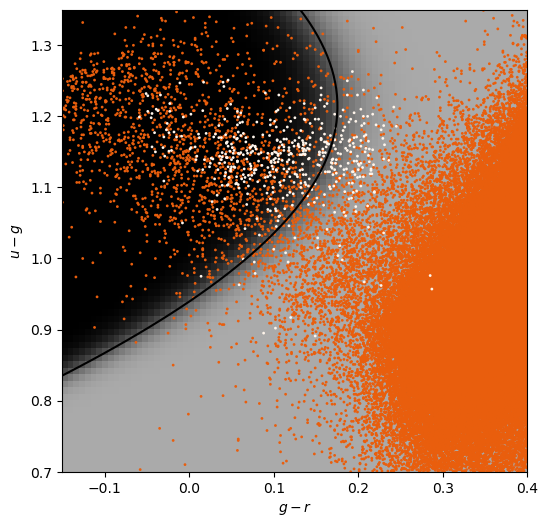

In [12]:
# I originally wanted to do model = classifier[1]  
## Unfortunately The above instanciation (classification based on 2 colors) does not work: (g-r) and (u-g)
model = GaussianNB()
n_colors=2
model.fit(X_train[:, :n_colors], y_train) # 3. fit model to data
y_predict = model.predict(X_test[:, :n_colors]) # 4. predict on new data
maketwocolors_RRlyrae_DB(model)

Contamination = 0.84, Completeness = 0.72, accuracy = 0.98


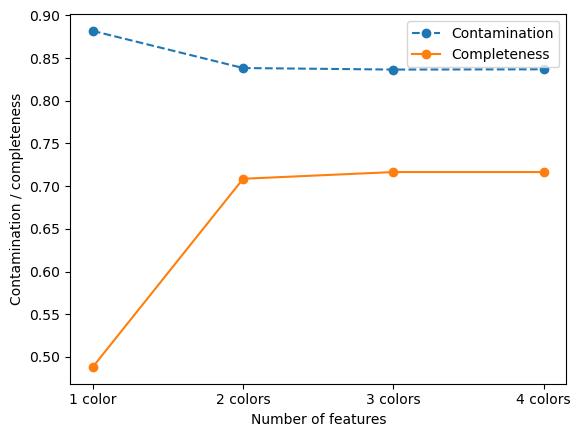

In [13]:
# Now we can look at the completeness and contamination of the LDA 
model = LDA()
compl, contam, acc, classifier =  calc_RRLyrae_score(model, X_train, y_train, X_test, y_test)  
Nfeatures = ['1 color', '2 colors', '3 colors', '4 colors']
plt.plot(Nfeatures, np.array(contam), marker='o', ls='--', label='Contamination')
plt.plot(Nfeatures, np.array(compl), marker='o', ls='-', label='Completeness')
plt.legend()
plt.xlabel('Number of features')
plt.ylabel('Contamination / completeness')
print('Contamination = %.2f, Completeness = %.2f, accuracy = %.2f' %(contam[3], compl[3], acc[3]))

completeness_LDA = np.array(compl).copy()
contamination_LDA = np.array(contam).copy()
accuracy_LDA = np.array(acc).copy()

(5751, 2)


<Axes: xlabel='$g-r$', ylabel='$u-g$'>

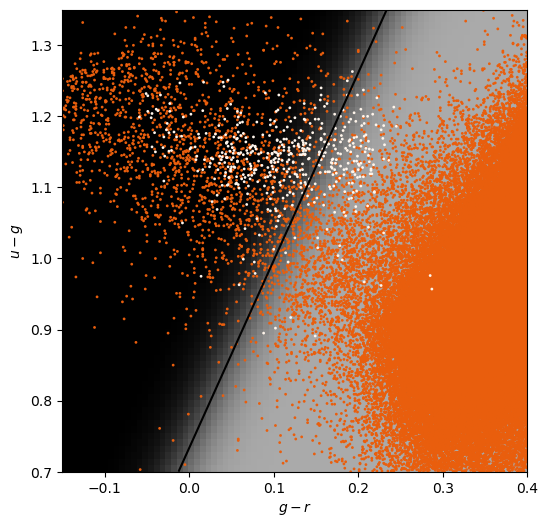

In [14]:
# Visualisation of decision boundary in 2D
model = LDA()
n_colors=2
model.fit(X_train[:, :n_colors], y_train) # 3. fit model to data
y_predict = model.predict(X_test[:, :n_colors]) # 4. predict on new data
maketwocolors_RRlyrae_DB(model)

This works less well than the GNB. In fact, plotting the decision boundary shows that the boundary is linear. 

Contamination = 0.79, Completeness = 0.81, accuracy = 0.98


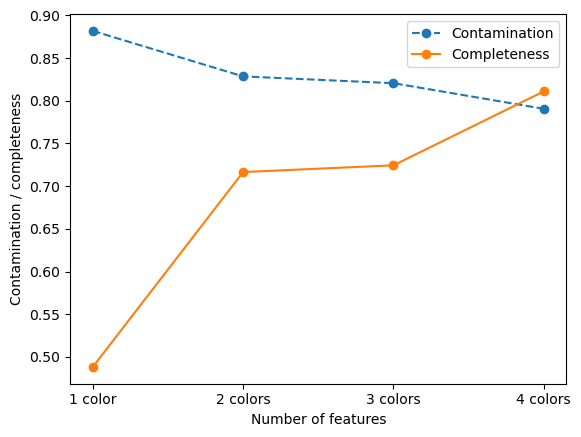

In [15]:
model = QDA()
compl, contam, acc, classifier =  calc_RRLyrae_score(model, X_train, y_train, X_test, y_test)  
Nfeatures = ['1 color', '2 colors', '3 colors', '4 colors']
plt.plot(Nfeatures, np.array(contam), marker='o', ls='--', label='Contamination')
plt.plot(Nfeatures, np.array(compl), marker='o', ls='-', label='Completeness')
plt.legend()
plt.xlabel('Number of features')
plt.ylabel('Contamination / completeness')
print('Contamination = %.2f, Completeness = %.2f, accuracy = %.2f' %(contam[3], compl[3], acc[3]))

completeness_QDA = np.array(compl).copy()
contamination_QDA = np.array(contam).copy()
accuracy_QDA = np.array(acc).copy()

(5751, 2)


<Axes: xlabel='$g-r$', ylabel='$u-g$'>

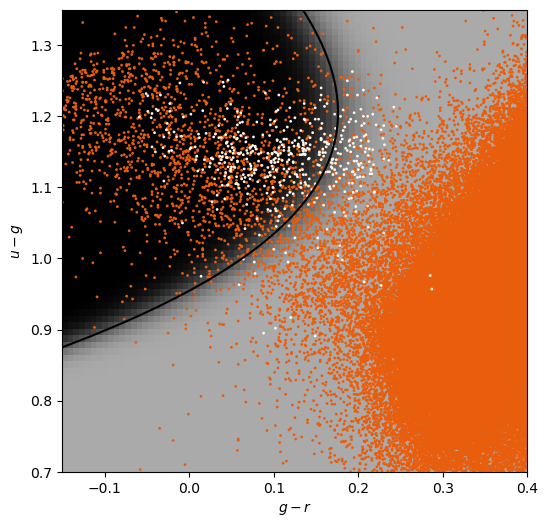

In [16]:
# Visualisation of decision boundary in 2D
model = QDA()
n_colors=2
model.fit(X_train[:, :n_colors], y_train) # 3. fit model to data
y_predict = model.predict(X_test[:, :n_colors]) # 4. predict on new data
maketwocolors_RRlyrae_DB(model)

Contamination = 0.79, Completeness = 0.81, accuracy = 0.98


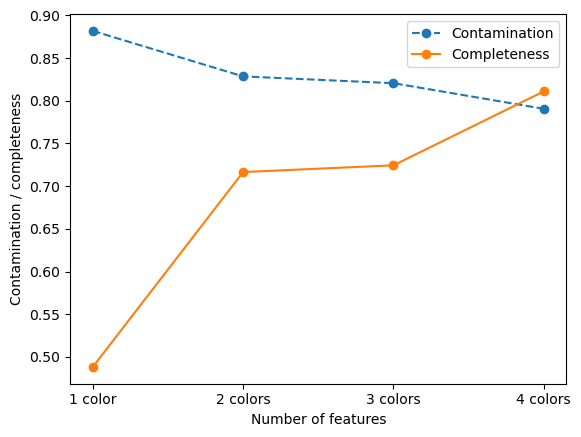

In [17]:
### Now testing GMM 
model = GMMBayes(n_components=1)
compl, contam, acc, classifier =  calc_RRLyrae_score(model, X_train, y_train, X_test, y_test)  
Nfeatures = ['1 color', '2 colors', '3 colors', '4 colors']
plt.plot(Nfeatures, np.array(contam), marker='o', ls='--', label='Contamination')
plt.plot(Nfeatures, np.array(compl), marker='o', ls='-', label='Completeness')
plt.legend()
plt.xlabel('Number of features')
plt.ylabel('Contamination / completeness')
print('Contamination = %.2f, Completeness = %.2f, accuracy = %.2f' %(contam[3], compl[3], acc[3]))

completeness_GMM = np.array(compl).copy()
contamination_GMM = np.array(contam).copy()
accuracy_GMM = np.array(acc).copy()


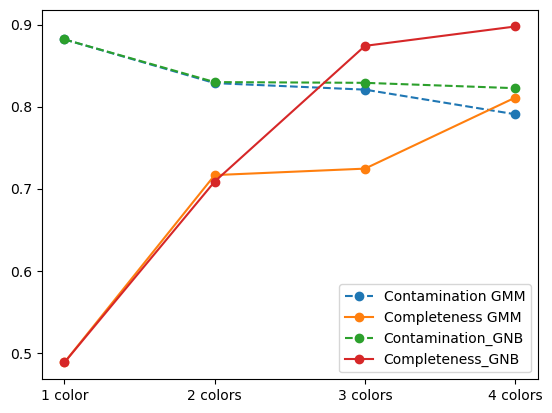

In [18]:
plt.plot(Nfeatures, np.array(contamination_GMM), marker='o', ls='--', label='Contamination GMM')
plt.plot(Nfeatures, np.array(completeness_GMM), marker='o', ls='-', label='Completeness GMM')

plt.plot(Nfeatures, contamination_GNB, marker='o', ls='--', label='Contamination_GNB')
plt.plot(Nfeatures, completeness_GNB, marker='o', ls='-', label='Completeness_GNB')
plt.legend()

GMM yields similar results to the GNB ... but performs less well at higher dimension (except that the contamination drops a bit which is good). 

/var/folders/9c/nn9vyf350tq3pbbll3zq6n8h0000gn/T/ipykernel_77564/4149452515.py:15: RuntimeWarning: invalid value encountered in scalar divide
  cont = fp / (tp + fp)


Contamination = 0.33, Completeness = 0.68, accuracy = 1.00


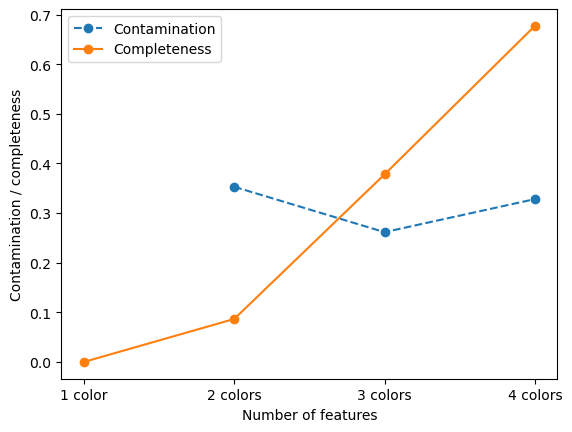

In [19]:
### Now testing GMM with 3 components
model = GMMBayes(n_components=3)
compl, contam, acc, classifier =  calc_RRLyrae_score(model, X_train, y_train, X_test, y_test)  
Nfeatures = ['1 color', '2 colors', '3 colors', '4 colors']
plt.plot(Nfeatures, np.array(contam), marker='o', ls='--', label='Contamination')
plt.plot(Nfeatures, np.array(compl), marker='o', ls='-', label='Completeness')
plt.legend()
plt.xlabel('Number of features')
plt.ylabel('Contamination / completeness')

print('Contamination = %.2f, Completeness = %.2f, accuracy = %.2f' %(contam[3], compl[3], acc[3]))

completeness_GMM3 = np.array(compl).copy()
contamination_GMM3 = np.array(contam).copy()
accuracy_GMM3 = np.array(acc).copy()


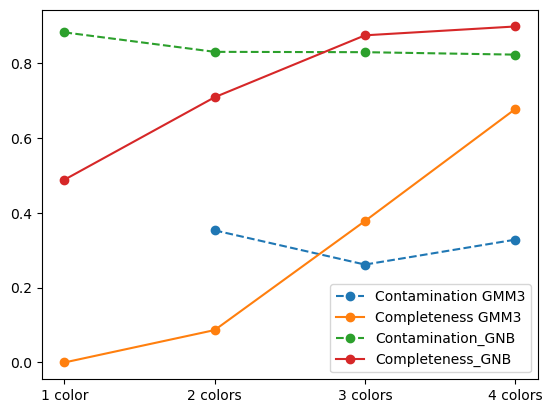

In [20]:
plt.plot(Nfeatures, np.array(contamination_GMM3), marker='o', ls='--', label='Contamination GMM3')
plt.plot(Nfeatures, np.array(completeness_GMM3), marker='o', ls='-', label='Completeness GMM3')

plt.plot(Nfeatures, contamination_GNB, marker='o', ls='--', label='Contamination_GNB')
plt.plot(Nfeatures, completeness_GNB, marker='o', ls='-', label='Completeness_GNB')
plt.legend()

(5751, 2)


<Axes: xlabel='$g-r$', ylabel='$u-g$'>

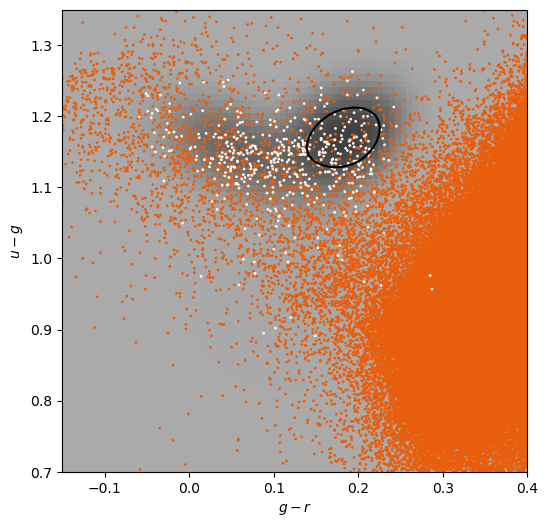

In [21]:
model = GMMBayes(n_components=3)
n_colors=2
model.fit(X_train[:, :n_colors], y_train) # 3. fit model to data
y_predict = model.predict(X_test[:, :n_colors]) # 4. predict on new data
maketwocolors_RRlyrae_DB(model)

The main asset of the GMM is that it captures the complex shape of the RR-lyrae density. It clearly makes a better job at capturing the RR-Lyrae density. 

Contamination = 0.34, Completeness = 0.62, accuracy = 1.00


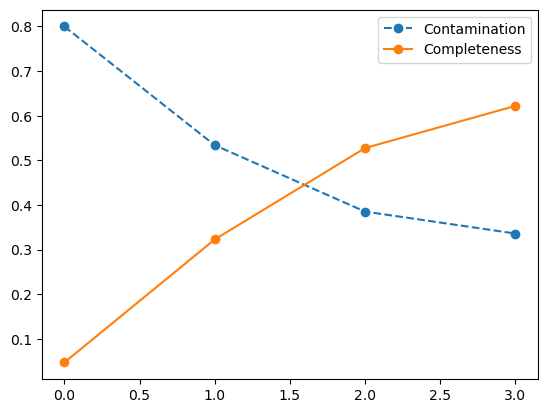

In [22]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
compl, contam, acc, classifier =  calc_RRLyrae_score(model, X_train, y_train, X_test, y_test)  
plt.plot(np.array(contam), marker='o', ls='--', label='Contamination')
plt.plot(np.array(compl), marker='o', ls='-', label='Completeness')
plt.legend()
print('Contamination = %.2f, Completeness = %.2f, accuracy = %.2f' %(contam[3], compl[3], acc[3]))

completeness_KNN = np.array(compl).copy()
contamination_KNN = np.array(contam).copy()
accuracy_KNN = np.array(acc).copy()

(5751, 2)


<Axes: xlabel='$g-r$', ylabel='$u-g$'>

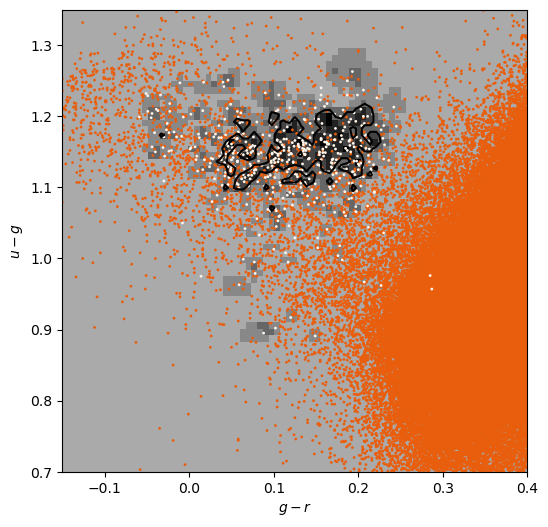

In [23]:
model = KNeighborsClassifier(n_neighbors=5)
n_colors=2
model.fit(X_train[:, :n_colors], y_train) # 3. fit model to data
y_predict = model.predict(X_test[:, :n_colors]) # 4. predict on new data
maketwocolors_RRlyrae_DB(model)

We get a relatively low contamination and a rather irregular boundary. It however performs less well than the GMM (for the tested values). 

## Summary of the different methods

In [24]:
c_names = ['NB ', 'LDA', 'QDA', 'GMM', 'KNN']
completeness = [completeness_GNB, completeness_LDA, completeness_QDA, completeness_GMM, completeness_KNN]
accuracy = [accuracy_GNB, accuracy_LDA, accuracy_QDA, accuracy_GMM, accuracy_KNN]
contamination = [contamination_GNB, contamination_LDA, contamination_QDA, contamination_GMM, contamination_KNN]
print('name | ACC   | CPL   | CONT')
print('----------------------------')
for cn, cpl, acc, cont in zip(c_names, completeness, accuracy, contamination):
    print(cn, ' | %.2f' %acc[3], ' | %.2f' %cpl[3], ' | %.2f' %cont[3])

name | ACC   | CPL   | CONT
----------------------------
NB   | 0.98  | 0.90  | 0.82
LDA  | 0.98  | 0.72  | 0.84
QDA  | 0.98  | 0.81  | 0.79
GMM  | 0.98  | 0.81  | 0.79
KNN  | 1.00  | 0.62  | 0.34


## Exploration paths for improving the results: 

In real life, you would consider improving those results following different paths. 
The use of PCA before running the classifier (there is correlations between the colors, hence, it could be that working with PCA will help) could help. 
Estimating Best parameters of classifiers should be based on on cross validation. 

## Other classifiers applied on RR-Lyrae data set 

Contamination = 0.74, Completeness = 0.95, accuracy = 0.99


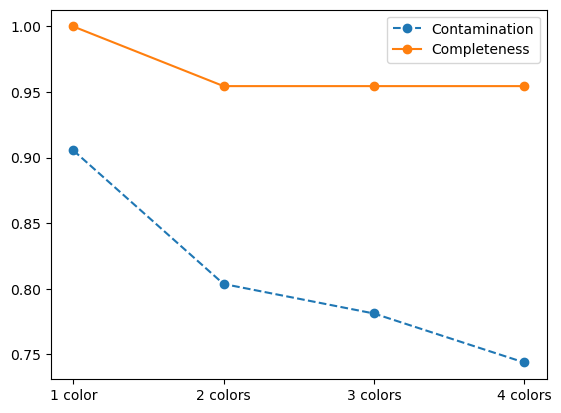

In [35]:
# Applying the SVC 
from sklearn.svm import SVC
# THIS IS rather time consuming (one can take 1/5 of the sample to speed things up)
X_trunc, y_trunc = X[::5], y[::5]
X_train, X_test, y_train, y_test = train_test_split(X_trunc, y_trunc,random_state=1)
model = SVC(C=10.01, kernel='rbf', gamma=20.0, class_weight='balanced', probability=True)

compl, contam, acc, classifier =  calc_RRLyrae_score(model, X_train, y_train, X_test, y_test)  
plt.plot(Nfeatures, np.array(contam), marker='o', ls='--', label='Contamination')
plt.plot(Nfeatures, np.array(compl), marker='o', ls='-', label='Completeness')
plt.legend()
print('Contamination = %.2f, Completeness = %.2f, accuracy = %.2f' %(contam[3], compl[3], acc[3]))

completeness_SVC = np.array(compl).copy()
contamination_SVC = np.array(contam).copy()
accuracy_SVC = np.array(acc).copy()

The results are pretty sensitive to the value of 'C' as well as on the choice of kernel. A larger C enable to keep high completeness but with lower contamination. 

(5751, 2)


<Axes: xlabel='$g-r$', ylabel='$u-g$'>

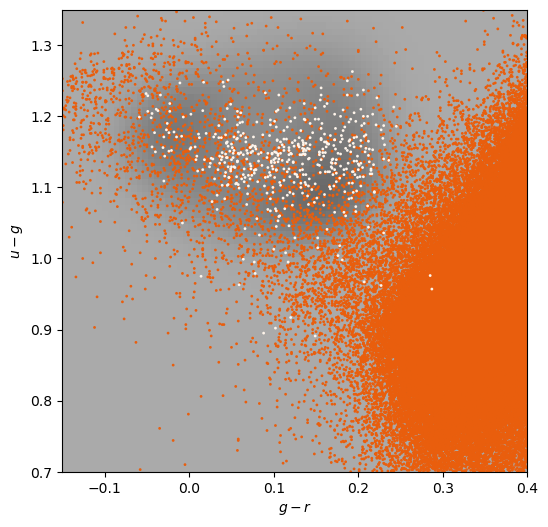

In [36]:
model = SVC(C=10.01, kernel='rbf', gamma=20.0, class_weight='balanced', probability=True)
n_colors=2
model.fit(X_train[:, :n_colors], y_train) # 3. fit model to data
y_predict = model.predict(X_test[:, :n_colors]) # 4. predict on new data
maketwocolors_RRlyrae_DB(model)

In [74]:
# What if we rescale ; Resclaing is not enough. Class_weight='balanced' is crucial !
#from sklearn.preprocessing import StandardScaler
#n_colors=2
#scaler = StandardScaler()
#X_train_nw = scaler.fit_transform(X_train)
#X_test_nw = scaler.fit_transform(X_test)
#model = SVC(kernel='rbf', C=1, probability=True, class_weight='balanced')
#model.fit(X_train_nw[:, :n_colors], y_train) # 3. fit model to data
#y_predict_nw = model.predict(X_test_nw[:, :n_colors]) # 4. predict on new data
#confusion_matrix(y_test, y_predict_nw)

array([[22514,   645],
       [    3,   124]])

Contamination = 0.45, Completeness = 0.55, accuracy = 1.00


/var/folders/9c/nn9vyf350tq3pbbll3zq6n8h0000gn/T/ipykernel_77564/4149452515.py:15: RuntimeWarning: invalid value encountered in scalar divide
  cont = fp / (tp + fp)


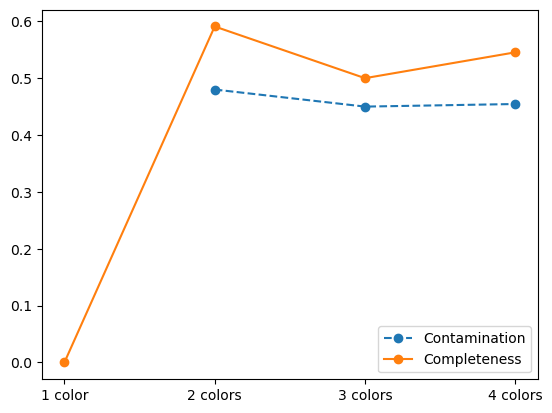

In [38]:
# Decision tree 
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=5, criterion='gini') #criterion='entropy')
compl, contam, acc, classifier =  calc_RRLyrae_score(model, X_train, y_train, X_test, y_test)  
plt.plot(Nfeatures, np.array(contam), marker='o', ls='--', label='Contamination')
plt.plot(Nfeatures, np.array(compl), marker='o', ls='-', label='Completeness')
plt.legend()
print('Contamination = %.2f, Completeness = %.2f, accuracy = %.2f' %(contam[3], compl[3], acc[3]))

completeness_DT = np.array(compl).copy()
contamination_DT = np.array(contam).copy()
accuracy_DT = np.array(acc).copy()

It naturally works better with multiple features. 
It is accurate but there is high contamination and low completeness ... So not so good. 

(5751, 2)


<Axes: xlabel='$g-r$', ylabel='$u-g$'>

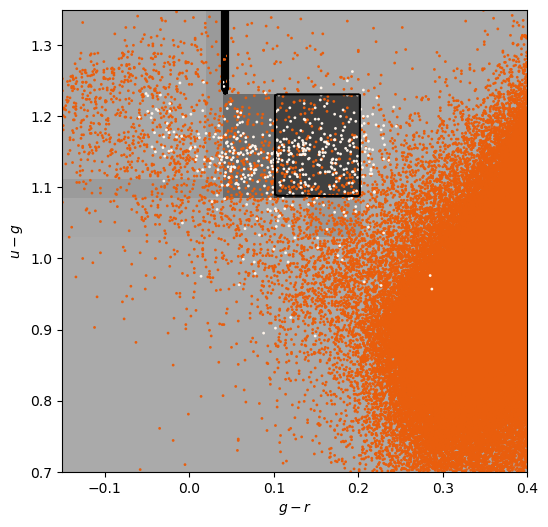

In [39]:
model = DecisionTreeClassifier(max_depth=5, criterion='gini') 
n_colors=2
model.fit(X_train[:, :n_colors], y_train) # 3. fit model to data
y_predict = model.predict(X_test[:, :n_colors]) # 4. predict on new data
maketwocolors_RRlyrae_DB(model)

Contamination = 0.43, Completeness = 0.36, accuracy = 1.00


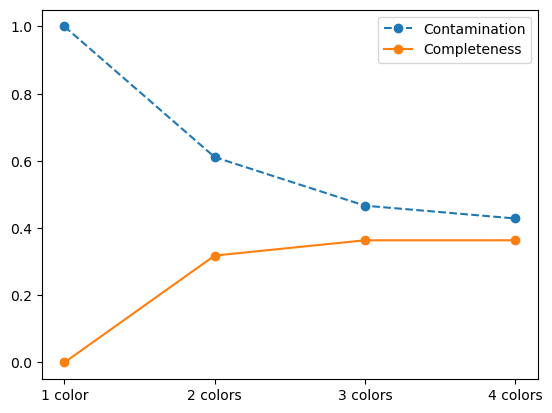

In [46]:
# Bagging
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
model = BaggingClassifier(DecisionTreeClassifier(random_state=42), 
                              n_estimators=500, max_samples=10000, 
                              bootstrap=True, random_state=42, n_jobs=-1)

compl, contam, acc, classifier =  calc_RRLyrae_score(model, X_train, y_train, X_test, y_test)  
plt.plot(Nfeatures, np.array(contam), marker='o', ls='--', label='Contamination')
plt.plot(Nfeatures, np.array(compl), marker='o', ls='-', label='Completeness')
plt.legend()
print('Contamination = %.2f, Completeness = %.2f, accuracy = %.2f' %(contam[3], compl[3], acc[3]))

completeness_DT_Bag = np.array(compl).copy()
contamination_DT_Bag = np.array(contam).copy()
accuracy_DT_Bag = np.array(acc).copy()

We need to have a large max. number of bootstrap sample to get a sensible result. A possible reason for this need of a large number of bootstraps is the fact that the class is unbalanced, such that there are many bootstrap samples that have no/few RR-Lyrae, precluding bootstraping. 
The result with ONE color seems awesome but does not make sense. 

Contamination = 0.43, Completeness = 0.36, accuracy = 1.00


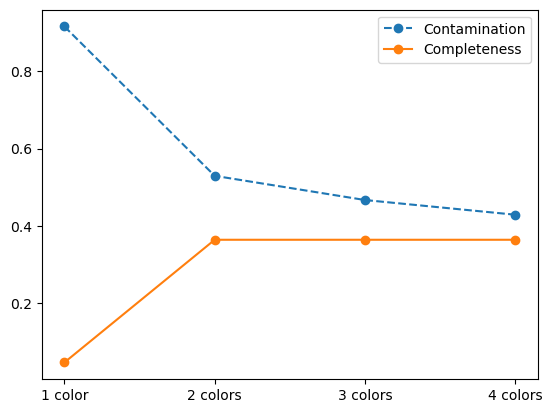

In [45]:
# Random Forest Classifier 
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(1000)

compl, contam, acc, classifier =  calc_RRLyrae_score(model, X_train, y_train, X_test, y_test)  
plt.plot(Nfeatures, np.array(contam), marker='o', ls='--', label='Contamination')
plt.plot(Nfeatures, np.array(compl), marker='o', ls='-', label='Completeness')
plt.legend()
print('Contamination = %.2f, Completeness = %.2f, accuracy = %.2f' %(contam[3], compl[3], acc[3]))

completeness_RF = np.array(compl).copy()
contamination_RF = np.array(contam).copy()
accuracy_RF = np.array(acc).copy()

Gives results pretty similar to Bagging. 

(5751, 2)


<Axes: xlabel='$g-r$', ylabel='$u-g$'>

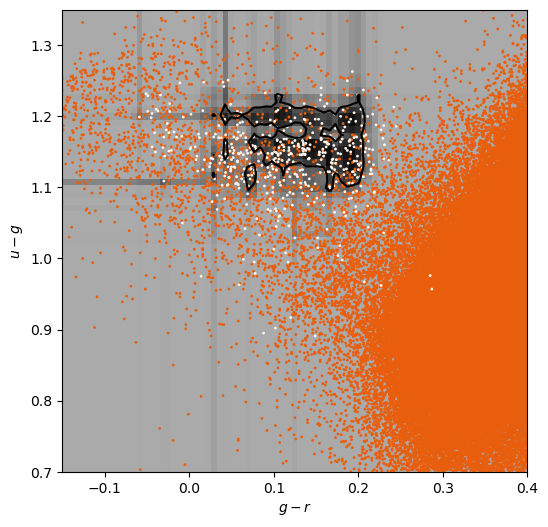

In [48]:
model = RandomForestClassifier(1000)
n_colors=2
model.fit(X_train[:, :n_colors], y_train) # 3. fit model to data
y_predict = model.predict(X_test[:, :n_colors]) # 4. predict on new data
maketwocolors_RRlyrae_DB(model)

In [51]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


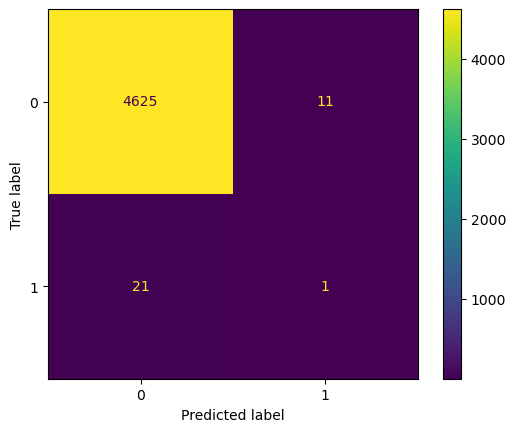

In [52]:
model = RandomForestClassifier(1000)
n_colors=1
model.fit(X_train[:, :n_colors], y_train) # 3. fit model to data
y_predict = model.predict(X_test[:, :n_colors]) # 4. predict on new data
c_mat = confusion_matrix(y_test, y_predict)
c_mat_display = ConfusionMatrixDisplay(c_mat).plot()

We have only one RR-lyrae as TP ... 

## Calculating ROC curves for the RR-Lyrae 

In [53]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from astroML.utils import completeness_contamination
#from sklearn.metrics import accuracy_score 

In [54]:
# Function that redo-the classification for 4 colors 

def mypipe_ROC(model, Xscaled, Y, rnd=1, showROC=True): 
    '''
    Calculates a ROC curve for a specific classifier 

    model: Instance of a sklearn classifier
    Xscaled: X feature of np.array  (scaled or not)
    Y: target (np.array)
    rnd: random state for spliting the sample into training and test sets 
    '''
    X_train, X_test, y_train, y_test = train_test_split(Xscaled, Y,random_state=rnd)
    model.fit(X_train, y_train) # 3. fit model to data
    y_predict = model.predict(X_test) # 4. predict on new data
    # Calculate an accuracy score for the test set 
    acc = accuracy_score(y_test, y_predict)
    completns, contam = completeness_contamination(y_predict, y_test)
    print('Accuracy = %.3f , Completeness = %.3f ; Contamination = %.3f ' %(acc, completns, contam))
    y_proba = model.predict_proba(X_test)
    roc = roc_curve(y_test, y_proba[:,1])
    if showROC:
        roc_disp = RocCurveDisplay.from_estimator(model, X_test, y_test)
    return completns, contam, acc, roc

In [55]:
# Reloading the data and re-aranging the columns 
X, y = fetch_rrlyrae_combined() # X is a 4-D color-color-color-color space
# Look the data format and re-organise the columns order for better 1 color classification
print(X.shape, y.shape)
X = X[:, [1, 0, 2, 3]]  # rearrange columns for better 1-color results ; not mandaotry here

(93141, 4) (93141,)


Accuracy = 0.977 , Completeness = 0.898 ; Contamination = 0.822 


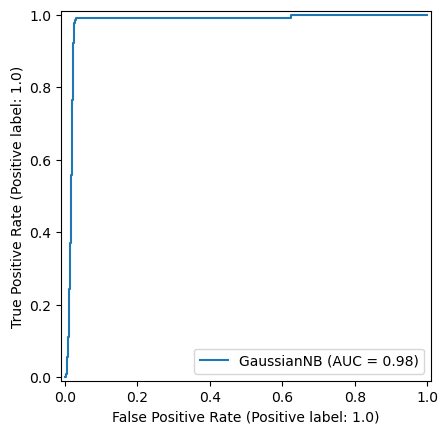

In [56]:
# Example with one classifier, before automatizing a bit more
# gaussNB 
result_dict = {} 
res_NB = mypipe_ROC(GaussianNB(), X, y)
result_dict['res_GNB'] = res_NB

In [57]:
res = mypipe_ROC(LDA(), X, y, showROC=False)
result_dict['res_LDA'] = res

Accuracy = 0.978 , Completeness = 0.717 ; Contamination = 0.837 


In [58]:
# Let's calculate the ROC curves for the generative classifiers
result_dict = {} 
clf_list = [GaussianNB(), LDA(), QDA(), GMMBayes(n_components=3), KNeighborsClassifier(n_neighbors=10)]
clf_names = ['GNB', 'LDA', 'QDA', 'GMM', 'KNC']
for i, clf in enumerate(clf_list):
    print(clf_names[i])
    res = mypipe_ROC(clf, X, y, showROC=False)
    result_dict['res_%s'%clf_names[i]] = res

GNB
Accuracy = 0.977 , Completeness = 0.898 ; Contamination = 0.822 
LDA
Accuracy = 0.978 , Completeness = 0.717 ; Contamination = 0.837 
QDA
Accuracy = 0.982 , Completeness = 0.811 ; Contamination = 0.791 
GMM
Accuracy = 0.996 , Completeness = 0.669 ; Contamination = 0.336 
KNC
Accuracy = 0.996 , Completeness = 0.543 ; Contamination = 0.317 


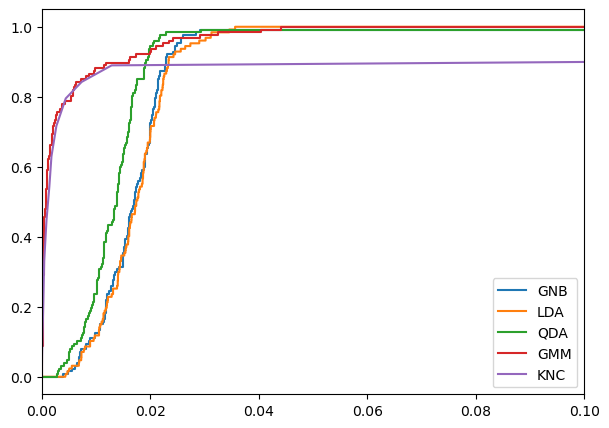

In [59]:
# Let's now compare the ROC curves
f, ax = plt.subplots(ncols=1, figsize=(7, 5))
for i, clf_name in enumerate(clf_names):
    FPR, TPR, thresh = result_dict['res_%s'%clf_name][3]
    ax.plot(FPR, TPR, label=clf_names[i])
    ax.legend()
    ax.set_xlim(0,0.1)

## Trying handwritten digits 

In [60]:
from sklearn.datasets import load_digits

digits = load_digits()
print(digits.images.shape)
print(digits.data.shape)
print(digits.keys())

(1797, 8, 8)
(1797, 64)
dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


In [61]:
def mypipe_ROC(model, Xscaled, Y, rnd=1, showROC=True): 
    '''
    Calculates a ROC curve for a specific classifier 

    model: Instance of a sklearn classifier
    Xscaled: X feature of np.array  (scaled or not)
    Y: target (np.array)
    rnd: random state for spliting the sample into training and test sets 
    '''
    X_train, X_test, y_train, y_test = train_test_split(Xscaled, Y,random_state=rnd)
    model.fit(X_train, y_train) # 3. fit model to data
    y_predict = model.predict(X_test) # 4. predict on new data
    # Calculate an accuracy score for the test set 
    acc = accuracy_score(y_test, y_predict)
    completns, contam = completeness_contamination(y_predict, y_test)
    print('Accuracy = %.3f , Completeness = %.3f ; Contamination = %.3f ' %(acc, completns, contam))
    y_proba = model.predict_proba(X_test)
    try:
        roc = roc_curve(y_test, y_proba[:,1])
        if showROC:
            roc_disp = RocCurveDisplay.from_estimator(model, X_test, y_test)
        return completns, contam, acc, roc
    except:
        print('Cannot plot roc')
    return completns, contam, acc

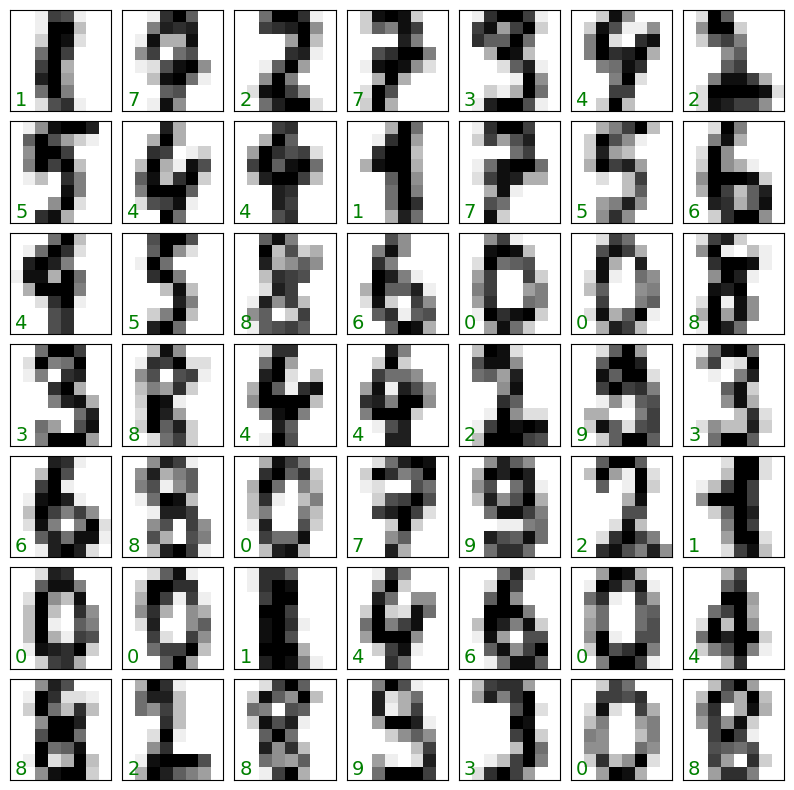

In [62]:
fig, axes = plt.subplots(7,7, figsize=(10, 10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

np.random.seed(42)
mychoices = np.random.choice(digits.images.shape[0],100)

for i, ax in enumerate(axes.flat):
    ax.imshow((digits.images[mychoices[i]]), 
              cmap='binary')
    ax.text(0.05, 0.05, str(digits.target[mychoices[i]]),transform=ax.transAxes, color='green', fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
    

In [63]:
X, y = digits.data, digits.target

In [69]:
# gaussNB 
result_dict = {} 
res_NB = mypipe_ROC(GaussianNB(), X, y)
result_dict['res_GNB'] = res_NB

Accuracy = 0.853 , Completeness = 0.839 ; Contamination = 0.006 
Cannot plot roc


In [70]:
# Let's calculate the ROC curves for the generative classifiers
result_dict = {} 
clf_list = [GaussianNB(), LDA(), QDA(), GMMBayes(n_components=3), KNeighborsClassifier(n_neighbors=10)]
clf_names = ['GNB', 'LDA', 'QDA', 'GMM', 'KNC']
for i, clf in enumerate(clf_list):
    print(clf_names[i])
    res = mypipe_ROC(clf, X, y, showROC=False)
    result_dict['res_%s'%clf_names[i]] = res

GNB
Accuracy = 0.853 , Completeness = 0.839 ; Contamination = 0.006 
Cannot plot roc
LDA
Accuracy = 0.967 , Completeness = 0.965 ; Contamination = 0.003 
Cannot plot roc
QDA


/Users/dsluse/miniconda3/envs/py_SPAT0086_py312/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/dsluse/miniconda3/envs/py_SPAT0086_py312/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/dsluse/miniconda3/envs/py_SPAT0086_py312/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/dsluse/miniconda3/envs/py_SPAT0086_py312/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matri

Accuracy = 0.882 , Completeness = 0.869 ; Contamination = 0.003 
Cannot plot roc
GMM
Accuracy = 0.691 , Completeness = 0.713 ; Contamination = 0.081 
Cannot plot roc
KNC
Accuracy = 0.993 , Completeness = 0.992 ; Contamination = 0.000 
Cannot plot roc


In [71]:
model = SVC(kernel='rbf', gamma=10.0, class_weight='balanced', probability=True)
rnd=42
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=rnd)
model.fit(X_train[:, :n_colors], y_train) # 3. fit model to data
y_predict = model.predict(X_test[:, :n_colors]) # 4. predict on new data
cmtx = confusion_matrix(y_test, y_predict).ravel()
#cpl = tp / (tp + fn)
#cont = fp / (tp + fp)
#acc = accuracy_score(y_test, y_predict)
#print('accuracy = %.2f, Completeness = %.2f, Contamination = %.2f,' %( acc, cpl, cont))

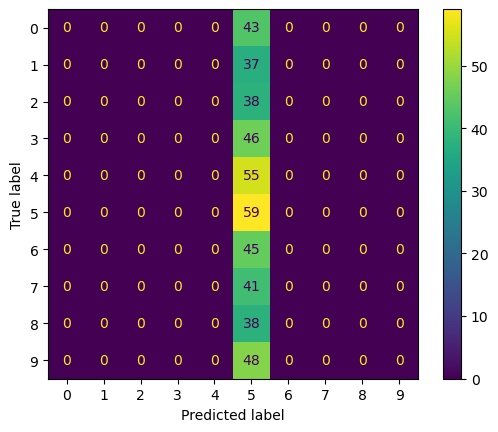

In [72]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
c_mat = confusion_matrix(y_test, y_predict)
c_mat_display = ConfusionMatrixDisplay(c_mat).plot()

Accuracy = 0.987 , Completeness = 0.985 ; Contamination = 0.000 


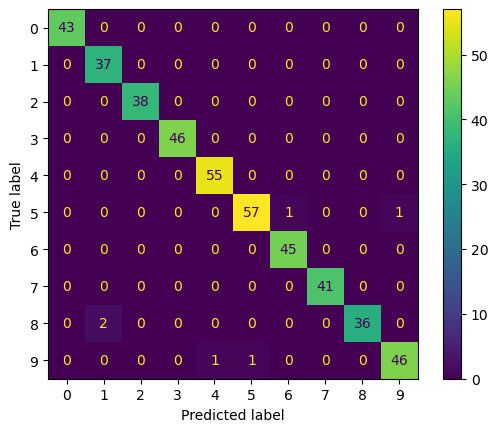

In [73]:
# The KNC seems to work great, let's have a deeper look
model = KNeighborsClassifier(n_neighbors=10)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=rnd)
model.fit(X_train, y_train) # 3. fit model to data
y_predict = model.predict(X_test) # 4. predict on new data
# Calculate an accuracy score for the test set 
acc = accuracy_score(y_test, y_predict)
completns, contam = completeness_contamination(y_predict, y_test)
print('Accuracy = %.3f , Completeness = %.3f ; Contamination = %.3f ' %(acc, completns, contam))
y_proba = model.predict_proba(X_test)
c_mat = confusion_matrix(y_test, y_predict)
c_mat_display = ConfusionMatrixDisplay(c_mat).plot()

At this stage, I would probably fine tune and make a grid search to find what would be the best number of neighbours 